<a href="https://colab.research.google.com/github/kmrasmussen/cell_project/blob/main/Section_5_2_Triplet_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA

In [ ]:
X = np.load('/content/gdrive/My Drive/uni_archive/cell_proj/experiments/experiment_outputs/simulated_gauss1_difficult1.npy')
y = np.load('/content/gdrive/My Drive/uni_archive/cell_proj/experiments/experiment_outputs/simulated_gauss1_labels_difficult1.npy')
y2 = np.load('/content/gdrive/My Drive/uni_archive/cell_proj/experiments/experiment_outputs/simulated_gauss1_labels2_difficult1.npy')

In [ ]:
batch1 = X[0:7000]
batch1_y2 = y2[0:7000]

In [ ]:
batch2 = X[7000:]
batch2_y2 = y2[7000:]

In [ ]:
k = 5
b1_nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(batch1)
b2_nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(batch2)
both_batches_nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)

In [ ]:
_, indices_knearest_b2_in_b1 = b1_nbrs.kneighbors(batch2)
_, indices_knearest_b1_in_b2 = b2_nbrs.kneighbors(batch1)

In [ ]:
def find_mnns(knearest_in_batch_2, knearest_in_batch_1):
    mnns = []
    # Go through each cell in batch 1 where you know its NN in batch 2
    for i in range(knearest_in_batch_2.shape[0]):
        # Select the batch 2 NNs for that batch 1 cell
        knearest_a = knearest_in_batch_2[i,:]
        # Go through all its NNs
        for j in knearest_a:
            # Does the NN in batch 2 also have this batch 1 cell as one of its NNs?
            if i in knearest_in_batch_1[j,:]:
                #i_vec = batch_1_with_effect[i,:]
                #j_vec = batch_2_with_effect[j,:]
                #cos_dist = distance.cosine(i_vec, j_vec)
                mnns.append((i,j))
    return mnns

In [ ]:
all_mnns = find_mnns(indices_knearest_b1_in_b2, indices_knearest_b2_in_b1)

In [ ]:
batch2_mnn_dict = {}
batch1_mnn_dict = {}
for batch1_cell, batch2_cell in all_mnns:
  if batch2_cell in batch2_mnn_dict:
    batch2_mnn_dict[batch2_cell].append(batch1_cell)
  else:
    batch2_mnn_dict[batch2_cell] = [batch1_cell]
  
  if batch1_cell in batch1_mnn_dict:
    batch1_mnn_dict[batch1_cell].append(batch2_cell)
  else:
    batch1_mnn_dict[batch1_cell] = [batch2_cell]

In [ ]:
class TripletCellDataset(Dataset):
  def __init__(self, both_batches, batch1, batch2, batch1_mnn_dict, batch2_mnn_dict, positive_sample_mode = 'other'):
    assert positive_sample_mode == 'other' or positive_sample_mode == 'all'
    self.X = both_batches
    self.b1 = batch1
    self.b2 = batch2
    self.b1_mnns = batch1_mnn_dict
    self.b2_mnns = batch2_mnn_dict
    self.positive_sample_mode = positive_sample_mode
    
  def __len__(self):
    return self.b1.shape[0] + self.b2.shape[0]

  def __getitem__(self, idx):
    batch_number = None
    anchor_batch = None
    anchor_id = None
    anchor = None
    positive_id = None
    positive = None
    negative_id = None
    negative = None
    if idx < self.b1.shape[0]:
      batch_number = 1
      anchor_batch = self.b1
      anchor_id = idx
      anchor = self.b1[anchor_id]
      if anchor_id in self.b1_mnns:
        anchor_mnns = np.array(self.b1_mnns[anchor_id])
        #print('Yay', anchor_id, ' in B1 has mnns', anchor_mnns)
        #print('labels', batch2_y2.take(anchor_mnns))
        #print('Anchor label', batch1_y2[anchor_id])
        positive_id = np.random.choice(anchor_mnns)
        positive = self.b2[positive_id]
      else:
        #print('Oops', anchor_id, ' in B1 does not have mnns')
        if self.positive_sample_mode == 'all':
          _, indices = both_batches_nbrs.kneighbors(batch1[anchor_id:anchor_id + 1])
          #print('K nearest in B2 to anchor', anchor_id, ' in B1', indices)
          positive_id = np.random.choice(indices[0])
          positive = self.X[positive_id]
        elif self.positive_sample_mode == 'other':
          _, indices = b2_nbrs.kneighbors(batch1[anchor_id:anchor_id + 1])
          positive_id = np.random.choice(indices[0])
          positive = self.b2[positive_id]
      #print('Positive id', positive_id)
      negative_id = np.random.randint(self.b1.shape[0])
      negative = self.b1[negative_id]
      #print('Choosing negative randomly', negative_id)
    else:
      batch_number = 2
      anchor_batch = self.b2
      anchor_id = idx - self.b1.shape[0]
      anchor = self.b2[anchor_id]
      if anchor_id in self.b2_mnns:
        anchor_mnns = np.array(self.b2_mnns[anchor_id])
        #print('Yay', anchor_id, ' in B2 has mnns', anchor_mnns, 'labels', batch1_y2.take(anchor_mnns))
        #print('Anchor label', batch2_y2[anchor_id])
        positive_id = np.random.choice(anchor_mnns)
        positive = self.b1[positive_id]
      else:
        if self.positive_sample_mode == 'all':
          #print('Oops', anchor_id, ' in B2 does not have mnns')
          _, indices = both_batches_nbrs.kneighbors(batch2[anchor_id:anchor_id + 1])
          #print('K nearest in B1 to anchor', anchor_id, ' in B2', indices)
          positive_id = np.random.choice(indices[0])
          positive = self.X[positive_id]
        elif self.positive_sample_mode == 'other':
          _, indices = b1_nbrs.kneighbors(batch2[anchor_id:anchor_id + 1])
          positive_id = np.random.choice(indices[0])
          positive = self.b1[positive_id]
      #print('Positive id', positive_id)
      negative_id = np.random.randint(self.b2.shape[0])
      negative = self.b2[negative_id]
      #print('Choosing negative randomly', negative_id)
    # batch_number, anchor_id, anchor, positive_id, positive, negative_id, negative
    return anchor, positive, negative


In [ ]:
sim_dataset = TripletCellDataset(X, batch1, batch2, batch1_mnn_dict, batch2_mnn_dict, positive_sample_mode='other')

In [ ]:
len(sim_dataset)

10000

In [ ]:
minibatch_size = 32
train_set, val_set, test_set = torch.utils.data.random_split(sim_dataset, [7000, 2000, 1000])
train_loader = DataLoader(train_set, batch_size=minibatch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=minibatch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=minibatch_size, shuffle=True)

In [ ]:
dataloader = DataLoader(sim_dataset, shuffle=True, batch_size=16)

In [ ]:
class TripletNet(nn.Module):
  def __init__(self, input_dim, hidden_dim, rep_dim):
    super().__init__()
    self.dense1 = nn.Linear(in_features = input_dim, out_features = hidden_dim)
    self.dense2 = nn.Linear(in_features = hidden_dim, out_features = rep_dim)

    # reconstructing decoder
    self.dec1 = nn.Linear(in_features=rep_dim, out_features=hidden_dim)
    self.dec2 = nn.Linear(in_features=hidden_dim, out_features=input_dim)

  def encode(self, x):
    x = F.relu(self.dense1(x))
    x = self.dense2(x)
    return x

  def decode(self, z):
    z = F.relu(self.dec1(z))
    z = self.dec2(z)
    return z

  def forward(self, x):
    encoding = self.encode(x)
    reconstruction = self.decode(encoding)
    return encoding, reconstruction

In [ ]:
def run_epoch(dataloader, mode = 'train'):
  assert mode == 'train' or mode == 'eval'
  running_loss = 0.
  running_recons_loss = 0.
  epoch_loss = 0.
  epoch_recons_loss = 0.
  for i, data in enumerate(dataloader):
    anchor, positive, negative = data

    if mode == 'train':
      optimizer.zero_grad()
      net.train()
    else:
      net.eval()
      
    anchor_embed, anchor_reconstruct = net(anchor.float())
    positive_embed, positive_reconstruct = net(positive.float())
    negative_embed, negative_reconstruct = net(negative.float())

    ap_dists = pairwise_dist(anchor_embed, positive_embed)
    an_dists = pairwise_dist(anchor_embed, negative_embed)
    pn_dists = pairwise_dist(negative_embed, positive_embed)
    losses = F.relu(ap_dists - an_dists + margin_hyperparam)
    loss = losses.sum()

    recons_loss_anchor = recons_loss(anchor_reconstruct, anchor) 
    recons_loss_postive = recons_loss(positive_reconstruct, positive) 
    recons_loss_negative = recons_loss(negative_reconstruct, negative)
    recons_loss_total = recons_loss_anchor + recons_loss_postive + recons_loss_negative

    if mode == 'train':
      loss.backward()
      optimizer.step()

    epoch_loss += loss.item()
    epoch_recons_loss += recons_loss_total.item()
    running_loss += loss.item()
    running_recons_loss += recons_loss_total.item()
    if i % 100 == 99:
      print('Running loss', np.round(running_loss / 100), ' RECONS', np.round(running_recons_loss / 100))
      running_loss = 0.
      running_recons_loss = 0.
  epoch_loss = epoch_loss / len(dataloader.dataset)
  epoch_recons_loss = epoch_recons_loss / len(dataloader.dataset)
  return epoch_loss, epoch_recons_loss

In [ ]:
net = TripletNet(500, 100, 20)
pairwise_dist = nn.PairwiseDistance(p = 2.)
margin_hyperparam = 0.
optimizer = optim.Adam(net.parameters())
recons_loss = torch.nn.MSELoss(reduce='sum')

train_history = []
val_history = []

n_epochs = 10
for epoch_i in range(n_epochs):
  print('')
  print('Epoch', epoch_i)
  train_loss, train_recons_loss = run_epoch(train_loader, mode = 'train')
  print('Train loss', train_loss)

  val_loss, val_recons_loss = run_epoch(val_loader, mode = 'eval')
  print('Val loss', val_loss)

  train_history.append(train_loss)
  val_history.append(val_loss)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Epoch 0
Running loss 15430.0  RECONS 3458218350.0
Running loss 4813.0  RECONS 3495112394.0
Train loss 308.74417009626114
Val loss 152.60253002929687

Epoch 1
Running loss 5200.0  RECONS 3524354783.0
Running loss 5450.0  RECONS 3564979086.0
Train loss 172.68186558314733
Val loss 234.612349609375

Epoch 2
Running loss 5519.0  RECONS 3494080563.0
Running loss 4794.0  RECONS 3492173631.0
Train loss 153.42248243931363
Val loss 65.21627478027344

Epoch 3
Running loss 4120.0  RECONS 3349059482.0
Running loss 2588.0  RECONS 3301919690.0
Train loss 105.45802390834264
Val loss 37.70566278076172

Epoch 4
Running loss 1760.0  RECONS 3216184989.0
Running loss 1411.0  RECONS 3164229144.0
Train loss 51.40128369140625
Val loss 60.985793853759766

Epoch 5
Running loss 1535.0  RECONS 3155334030.0
Running loss 1882.0  RECONS 3176802535.0
Train loss 50.86648776681083
Val loss 14.31952734375

Epoch 6
Running loss 1139.0  RECONS 3165762889.0
Running loss 841.0  RECONS 3136810964.0
Train loss 30.74231493268

In [ ]:
test_loss, test_recons_loss = run_epoch(test_loader, mode = 'eval')
test_loss

68.67898040771485

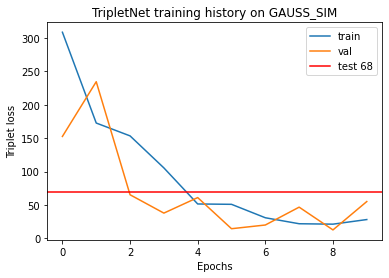

In [ ]:
plt.plot(train_history, label = 'train')
plt.plot(val_history, label = 'val')
plt.xlabel('Epochs')
plt.ylabel('Triplet loss')
plt.title('TripletNet training history on GAUSS_SIM')
plt.axhline(y = test_loss, color = 'red', label = 'test ' + str(int(test_loss)))
plt.legend()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Colab Cell Experiments/plots/tripletnet_gauss_sim_epoch10_history_b.png')

In [ ]:
X_encoded, X_reconstructed = net(torch.tensor(X).float())

In [ ]:
reducer = umap.UMAP()
X_encoded_umap = reducer.fit_transform(X_encoded.detach())

In [ ]:
pca = PCA(n_components = 2)
X_encoded_pca = pca.fit_transform(X_encoded.detach())

In [ ]:
#from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=3, random_state=0).fit(X_encoded_umap)

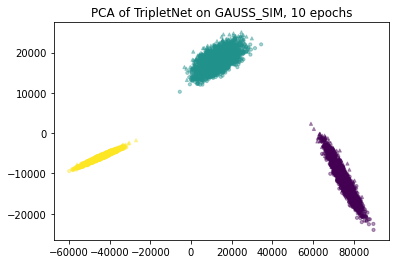

In [ ]:
plt.title('PCA of TripletNet on GAUSS_SIM, 10 epochs')
plt.scatter(X_encoded_pca[:7000][:,0], X_encoded_pca[:7000][:,1], c=y2[:7000], marker='o', s=10, alpha=0.4)
plt.scatter(X_encoded_pca[7000:][:,0], X_encoded_pca[7000:][:,1], c=y2[7000:], marker='^', s=10, alpha=0.4)
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Colab Cell Experiments/plots/tripletnet_gauss_epoch10_pca_b.png')
#plt.scatter(X_encoded_pca[:,0] + 5, X_encoded_pca[:,1] + 5, c=y2)

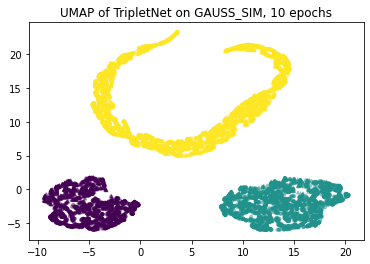

In [ ]:
plt.title('UMAP of TripletNet on GAUSS_SIM, 10 epochs')
plt.scatter(X_encoded_umap[:7000][:,0], X_encoded_umap[:7000][:,1], c=y2[:7000], marker='o', s=10, alpha=0.4)
plt.scatter(X_encoded_umap[7000:][:,0], X_encoded_umap[7000:][:,1], c=y2[7000:], marker='^', s=10, alpha=0.4)
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Colab Cell Experiments/plots/tripletnet_gauss_epoch10_umap_b.png')

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
X_encoded_tsne = TSNE(n_components=2).fit_transform(X_encoded.detach())

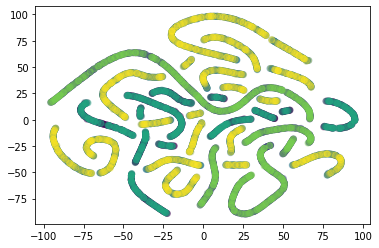

In [ ]:
plt.scatter(X_encoded_tsne[:,0], X_encoded_tsne[:,1], c=y2, alpha=0.2)

In [ ]:
reducer2 = umap.UMAP()
X_normal_umap = reducer2.fit_transform(X)

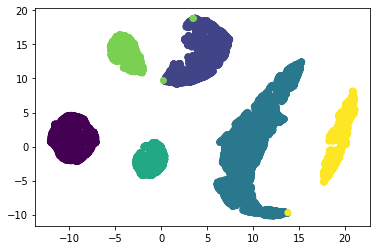

In [ ]:
plt.scatter(X_normal_umap[:,0], X_normal_umap[:,1], c=y2)